# Tutorial: Expression analysis with pygenlib and genemunge

This notebook contains a pygenlib/genemunge tutorial in which we:

* Instatiate the human transcriptome containing protein coding genes with pygenlib and extract gene length and exon counts
* Use genemunge to get a list of housekeeping genes, recount2 expression values and Hellinger distance values
* Plot the data


First, we install [genemunge](https://github.com/unlearnai/genemunge) a python package for accessing GTex/recount2 data. NOTE that installation of this package requires hdf5 to be installed. See [here](https://stackoverflow.com/questions/73029883/could-not-find-hdf5-installation-for-pytables-on-m1-mac) for installation via homebrew on MacOS.

In [ ]:
#!pip install genemunge

Now we can load all required packages.

In [67]:
# set path and load pygenlib
import os, pathlib, platform
PYGENLIB_SRC=pathlib.Path('/Users/niko/projects/pygenlib/') 
os.chdir(PYGENLIB_SRC)
# install libraries. Recommended to run in a venv here!
#!{sys.executable} -m pip install -r requirements.txt 
display(f"Running pygenlib on python {platform.python_version()}. Using pygenlib code from {PYGENLIB_SRC}")
# load pygenlib
import pygenlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import genemunge

'Running pygenlib on python 3.10.4. Using pygenlib code from /Users/niko/projects/pygenlib'

First, we download gencode v39 annotations.
NOTE that this needs bedtools, samtools and htslib (bgzip, tabix) installed.
Total size of the downloaded data (for all tutorials) is ~150M. Files are only downloaded if not existing already in the `notebooks/large_test_resources/` directory.

In [68]:
import traceback
from pygenlib.testdata import download_bgzip_slice
outdir=PYGENLIB_SRC / 'notebooks/large_test_resources' # update to your preferred location
large_test_resources = {
    "outdir": f"{outdir}", # update to your preferred location
    "resources": {
        # -------------- Full gencode39 annotation -------------------------------
        "full_gencode_gff": {
            "uri": "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_39/gencode.v39.annotation.gff3.gz",
            "filename": "gencode_39.gff3.gz",
            "recreate": False
        }   
    }
}
display(f'Downloading test data files to {outdir}')
for resname in large_test_resources['resources']:
    try:
        download_bgzip_slice(large_test_resources, resname, view_tempdir=False)
    except Exception:
        display(traceback.format_exc())
        display(f"Error creating resource {resname}. Some tests may not work...")
display("All done.")

'Downloading test data files to /Users/niko/projects/pygenlib/notebooks/large_test_resources'

Creating testdataset full_gencode_gff
Resource already exists, skipping...


'All done.'

Now, we build subset of human transcriptome containing only canonical, protein coding genes.

In [69]:
t=Transcriptome({
    'annotation_gff': get_resource("full_gencode_gff", conf=large_test_resources),
    'annotation_flavour': 'gencode',
    'transcript_filter': {
        'included_tags': ['Ensembl_canonical'],
        'included_genetypes': ['protein_coding'],
    },
    'load_sequences': False
})

Building transcriptome (Filtered (1 tags, 0 tids, 1 genetypes, 0 chroms, 0 regions).):   0%|          | 0/25 […

Build interval tree:   0%|          | 0/19982 [00:00<?, ?it/s]

Using genemunge, we retrieve a list of housekeeping genes, see see https://www.tau.ac.il/~elieis/HKG/

In [70]:
searcher = genemunge.search.Searcher()
housekeeping_genes = searcher.get_housekeeping_genes()
print(f'Identified {len(housekeeping_genes)} housekeeping genes')

Identified 3620 housekeeping genes


Finally, we can compile tissue-specific expression data for housekeeping and all other genes as
well as some gene-related values (average number of exons per tx, gene length).
We exemplary show data for three tissues ('Blood', 'Bone Marrow', 'Brain'), the expression values are tpm normalized.
Using the transcriptomer model, we can easily access gene length and average number of exons (which naturally correlate) for a downstream analysis.

In [71]:
def get_exp_data(t, genes, housekeeping_genes, tissues=('Blood',)):
    # set up an object to describe genes
    describer = genemunge.describe.Describer('symbol')
    # get major versions of gene ids
    ids = [g.feature_id.split('.')[0] for g in genes]
    # create dataframe
    expression_data = pd.DataFrame(index=ids, columns=['hellinger', 'len', 'n_exon', 'HK']+[f"exp_{tissue}" for tissue in tissues])
    # get gene lengths
    expression_data['len'] = [len(g) for g in genes]
    expression_data['n_exon'] = [np.mean([len(tx.exon) for tx in g.transcript]) for g in genes]
    # get the expression levels in healthy tissue (in TPM units)
    for tissue in tissues:
        expression_data[f"exp_{tissue}"] = describer.tissue_stats['median'].reindex(ids)[tissue]
    # get the hellinger distance 
    expression_data['hellinger'] = describer.tissue_stats['hellinger'].reindex(ids)
    # is it a HK gene?
    expression_data['HK']=['yes' if g.feature_id.split('.')[0] in housekeeping_genes else 'no' for g in genes]
    return expression_data

# get expression levels of each gene of interest
tissues=('Blood', 'Bone Marrow', 'Brain')
exp = get_exp_data(t, t.genes, housekeeping_genes, tissues)
exp.describe(include='all')

,hellinger,len,n_exon,HK,exp_Blood,exp_Bone Marrow,exp_Brain
count,19640.000000,1.998200e+04,19982.000000,19982,19640.000000,19640.000000,19640.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,no,NaN,NaN,NaN
freq,NaN,NaN,NaN,16374,NaN,NaN,NaN
mean,0.970893,6.877190e+04,10.475228,NaN,34.773819,33.032600,34.321095
std,0.049021,1.329786e+05,10.361035,NaN,1824.817139,386.487213,963.890137
min,0.339648,3.900000e+01,1.000000,NaN,0.000000,0.000000,0.000000
25%,0.963851,9.741000e+03,4.000000,NaN,0.067002,0.089170,0.490639
50%,0.987020,2.743100e+04,8.000000,NaN,1.147619,3.912210,3.808928
75%,0.998689,7.164075e+04,14.000000,NaN,6.222931,19.721184,11.014380


Now, we plot the tissue-specific expression and the Hellinger distance for housekeeping genes 
vs all others. 

Text(0.5, 0.98, 'Tissue specific expression and Hellinger distance, all vs HK genes')

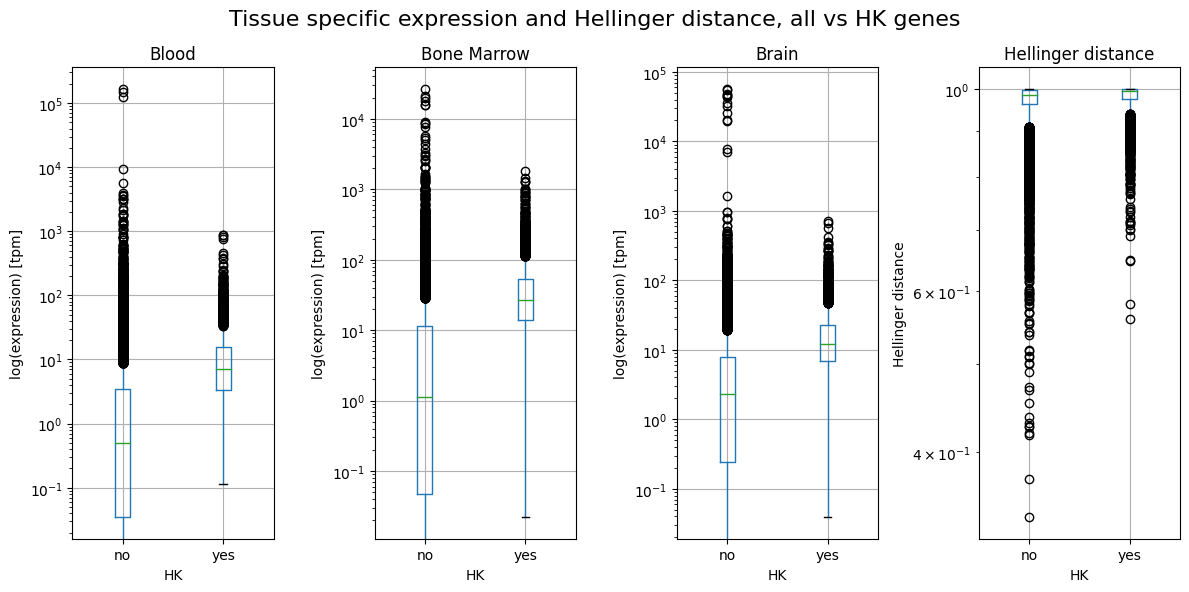

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
for i, tissue in enumerate(tissues):
    exp.boxplot(column=f"exp_{tissue}", by='HK', ax=ax[i])
    ax[i].set_yscale('log')
    ax[i].set_ylabel('log(expression) [tpm]')
    ax[i].set_title(tissue)
exp.boxplot(column='hellinger', by='HK', ax=ax[-1])
ax[-1].set_yscale('log')
ax[-1].set_title('Hellinger distance')
ax[-1].set_ylabel('Hellinger distance')
fig.tight_layout()
fig.suptitle(t='Tissue specific expression and Hellinger distance, all vs HK genes', fontsize=16)

As expected, housekeeping genes have higher expression levels. They also show higher
Hellinger distance values which range between 0 (all tissues have the same expression) and 1 (at least one tissue pair are easily distinguished).

Now, we plot the Hellinger distance vs number of exons and vs gene length. 

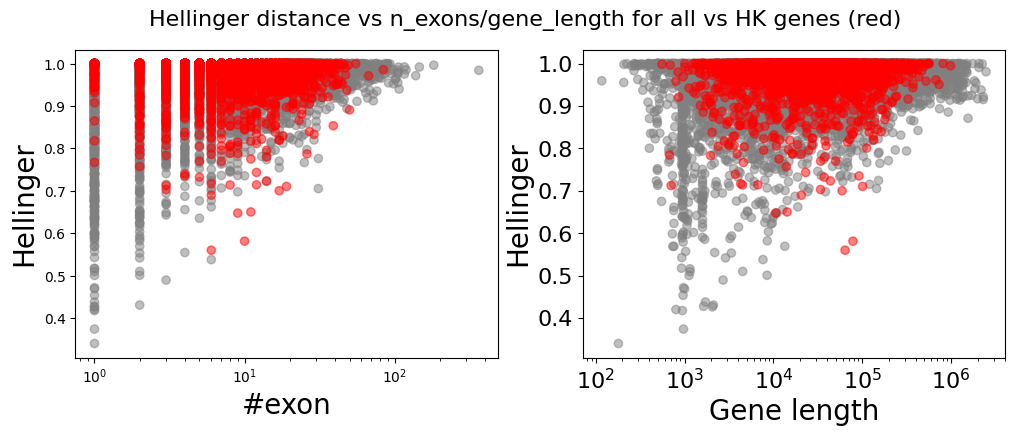

In [73]:
# plot hellinger distance vs gene length
exp=exp.sort_values('HK')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.scatter(exp['n_exon'], exp['hellinger'], color=exp['HK'].map({'no':'grey','yes':'red'}),alpha=0.5)
ax1.set_xlabel('#exon', fontsize=20)
ax1.set_xscale('log')
ax1.set_ylabel('Hellinger', fontsize=20)

ax2.scatter(exp['len'], exp['hellinger'], color=exp['HK'].map({'no':'grey','yes':'red'}),alpha=0.5)
ax2.set_xlabel('Gene length', fontsize=20)
ax2.set_xscale('log')
ax2.set_ylabel('Hellinger', fontsize=20)

fig.suptitle(t='Hellinger distance vs n_exons/gene_length for all vs HK genes (red)', fontsize=16);
plt.show()

Longer genes have higher Hellinger distance.